In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx

from oasis.functions import deconvolve
from scipy.stats import pearsonr

from utils.context_data_csv import ContextDataCSV
from utils.matrix_optimizer import MatrixOptimizer

import utils.sulfur.constant as const

/app/OASIS/oasis/functions.py:13: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  warn("Could not find cvxpy. Don't worry, you can still use OASIS, " +


In [2]:
engram_shock_cells = {
    'ID181106CreA': ['C261', 'C305', 'C347', 'C349', 'C351'],
    'ID181106CreB': ['C058', 'C089', 'C126'],
    'ID181106CreC': ['C017', 'C065', 'C112', 'C117', 'C203', 'C227'],
    'ID181106CreG': ['C127', 'C239', 'C323', 'C347', 'C350', 'C399', 'C402'],
    'ID181106CreH': ['C164', 'C180', 'C184', 'C243', 'C253', 'C298', 'C327', 'C351', 'C534', 'C542'],
    'ID181106CreI': ['C136', 'C197', 'C273', 'C292', 'C294', 'C306', 'C333'],
    'ID181106CreK': ['C083', 'C088', 'C100', 'C149', 'C390'],
    'ID181106CreL': ['C200'],
    'ID181106CreN': ['C199', 'C255', 'C258', 'C273'],
    'ID181106CreQ': ['C393']
}

non_engram_shock_cells = {
    'ID181106CreA': ['C000', 'C007', 'C009', 'C059', 'C076', 'C084', 'C086', 'C099', 'C101', 'C116', 'C120', 'C124', 'C141', 'C143', 'C145', 'C153', 'C164', 'C173', 'C175', 'C197', 'C198', 'C228', 'C234', 'C235', 'C284', 'C303', 'C306', 'C310', 'C317', 'C325', 'C327', 'C328', 'C336', 'C362', 'C377', 'C442', 'C459', 'C476', 'C479', 'C480', 'C487', 'C491', 'C493', 'C494', 'C519'],
    'ID181106CreB': ['C000', 'C003', 'C009', 'C010', 'C063', 'C066', 'C071', 'C072', 'C073', 'C080', 'C083', 'C088', 'C090', 'C094', 'C100', 'C103', 'C108', 'C109', 'C112', 'C114', 'C115', 'C127', 'C130', 'C131', 'C134', 'C166', 'C168', 'C169', 'C177', 'C178', 'C179', 'C200', 'C202', 'C203', 'C213', 'C230', 'C231', 'C268', 'C279', 'C282', 'C284'],
    'ID181106CreC': ['C002', 'C011', 'C012', 'C016', 'C019', 'C043', 'C045', 'C049', 'C050', 'C054', 'C055', 'C056', 'C058', 'C060', 'C063', 'C070', 'C072', 'C074', 'C076', 'C079', 'C084', 'C086', 'C088', 'C096', 'C105', 'C107', 'C118', 'C127', 'C132', 'C143', 'C144', 'C146', 'C153', 'C155', 'C160', 'C168', 'C186', 'C192', 'C193', 'C194', 'C198', 'C202', 'C205', 'C215', 'C219', 'C224', 'C233', 'C235', 'C237', 'C238', 'C239', 'C241', 'C256', 'C257', 'C262', 'C268', 'C272', 'C276', 'C287', 'C294', 'C295', 'C296'],
    'ID181106CreG': ['C003', 'C004', 'C005', 'C010', 'C011', 'C017', 'C025', 'C063', 'C067', 'C070', 'C071', 'C073', 'C076', 'C089', 'C102', 'C118', 'C126', 'C133', 'C136', 'C142', 'C157', 'C166', 'C177', 'C193', 'C197', 'C199', 'C204', 'C205', 'C210', 'C212', 'C229', 'C232', 'C244', 'C247', 'C249', 'C253', 'C261', 'C273', 'C286', 'C291', 'C293', 'C294', 'C298', 'C302', 'C304', 'C305', 'C309', 'C313', 'C325', 'C338', 'C344', 'C352', 'C353', 'C361', 'C377', 'C385', 'C426', 'C449', 'C458', 'C478'],
    'ID181106CreH': ['C018', 'C021', 'C059', 'C074', 'C081', 'C085', 'C087', 'C125', 'C127', 'C148', 'C160', 'C175', 'C203', 'C218', 'C232', 'C249', 'C252', 'C256', 'C261', 'C268', 'C271', 'C350', 'C361', 'C385', 'C386', 'C395', 'C397', 'C400', 'C404', 'C411', 'C475', 'C490', 'C493', 'C497', 'C498', 'C505', 'C511', 'C520', 'C521', 'C525', 'C529', 'C541', 'C579', 'C594', 'C603', 'C632', 'C636'],
    'ID181106CreI': ['C012', 'C049', 'C061', 'C143', 'C164', 'C166', 'C176', 'C183', 'C214', 'C249', 'C254', 'C256', 'C270', 'C275', 'C281', 'C302', 'C325', 'C326', 'C327', 'C341', 'C352', 'C368'],
    'ID181106CreK': ['C006', 'C045', 'C066', 'C071', 'C075', 'C080', 'C085', 'C102', 'C114', 'C117', 'C123', 'C124', 'C133', 'C136', 'C145', 'C178', 'C180', 'C202', 'C205', 'C206', 'C207', 'C208', 'C233', 'C238', 'C239', 'C243', 'C251', 'C262', 'C267', 'C277', 'C291', 'C297', 'C323', 'C325', 'C341', 'C352', 'C361', 'C376', 'C380', 'C399', 'C403', 'C411', 'C424', 'C428'],
    'ID181106CreL': ['C008', 'C015', 'C020', 'C021', 'C037', 'C040', 'C044', 'C049', 'C061', 'C069', 'C073', 'C074', 'C075', 'C082', 'C085', 'C123', 'C125', 'C126', 'C128', 'C129', 'C132', 'C133', 'C144', 'C150', 'C155', 'C162', 'C173', 'C180', 'C185', 'C196', 'C203', 'C209', 'C211', 'C213', 'C216', 'C224', 'C231', 'C236', 'C243', 'C255', 'C270', 'C273', 'C283', 'C298', 'C312', 'C315', 'C323', 'C332', 'C341', 'C343', 'C344', 'C346', 'C350', 'C353', 'C357', 'C373', 'C414', 'C416', 'C424', 'C439', 'C445', 'C456', 'C461', 'C463', 'C475', 'C498', 'C501'],
    'ID181106CreN': ['C008', 'C022', 'C028', 'C044', 'C048', 'C057', 'C062', 'C069', 'C079', 'C089', 'C098', 'C123', 'C144', 'C168', 'C186', 'C201', 'C204', 'C213', 'C217', 'C227', 'C228', 'C239', 'C261', 'C267', 'C288', 'C290', 'C301', 'C306', 'C309', 'C321', 'C343', 'C355', 'C391', 'C395', 'C397', 'C402', 'C404', 'C410', 'C412', 'C413', 'C416', 'C425', 'C429', 'C441', 'C463', 'C469', 'C490', 'C506', 'C511', 'C517'],
    'ID181106CreQ': ['C000', 'C001', 'C006', 'C009', 'C019', 'C022', 'C033', 'C034', 'C040', 'C042', 'C050', 'C055', 'C057', 'C059', 'C061', 'C070', 'C076', 'C089', 'C092', 'C098', 'C108', 'C118', 'C121', 'C122', 'C123', 'C127', 'C132', 'C134', 'C137', 'C168', 'C169', 'C173', 'C179', 'C181', 'C192', 'C202', 'C205', 'C207', 'C209', 'C214', 'C217', 'C239', 'C260', 'C263', 'C281', 'C284', 'C305', 'C308', 'C316', 'C325', 'C332', 'C333', 'C335', 'C336', 'C343', 'C347', 'C354', 'C362', 'C365', 'C368', 'C372', 'C374', 'C375', 'C380', 'C387', 'C398', 'C412', 'C417', 'C421', 'C426', 'C431', 'C434', 'C455', 'C456', 'C463', 'C464', 'C470', 'C485', 'C491']
}

In [3]:
all_shock_cells = {}
for animal_name in engram_shock_cells:
    all_shock_cells[animal_name] = engram_shock_cells[animal_name] + non_engram_shock_cells[animal_name]

In [4]:
index = const.ANIMAL_NAMES
columns_df = pd.DataFrame()
contexts = ['A1pre', 'A1post', 'A2_start', 'A2_end', 'A3_start', 'A3_end', 'A4pre', 'A4post', 'A5', 'A1_1', 'A1_2', 'A1_3', 'A4_1', 'A4_2', 'A4_3']
features = ['clustering coefficient', 'shortest path length', 'co-firing strength', 'average weight', 'average edges', 'assortativity']
context_columns = []
for context_name in contexts:
    context_columns += [context_name] * len(features)
columns_df.loc[:, 'context'] = context_columns
columns_df.loc[:, 'feature'] = features * len(contexts)
columns = pd.MultiIndex.from_frame(columns_df)

df = pd.DataFrame(0.0, index=index, columns=columns)

In [5]:
def fetch_preserved_shock_values(shock_cell_name, preserved_shocks):
    if shock_cell_name in preserved_shocks:
        return preserved_shocks[shock_cell_name]
    
    return None

def estimate_spike(matrix, cell_name):
    spike_threshold = 0.05
    
    values = matrix.loc[:, cell_name]
    
    if values.isnull().all():
        return np.zeros(len(values))
    
    _c, spikes, _b, _g, _lam = deconvolve(values.to_numpy(), g=(None, None), penalty=1)
    spikes[spikes <= spike_threshold] = 0.0
    
    return spikes

def append_preserved_shock_values(shock_cell_name, preserved_shocks, spikes):
    if shock_cell_name in preserved_shocks:
        return
    
    preserved_shocks[shock_cell_name] = spikes
    
def is_all_zeros_constant_array(array):
    return np.all(array == 0.0)

def calc_cofiring_graph(matrix, shock_cells, preserved_spikes, start_frame, end_frame):
    spike_threshold = 0.05
    pearsonr_threshold = 0.1
    graph = nx.Graph()
    
    for i in range(len(shock_cells)):
        base_shock_cell = shock_cells[i]
        
        base_spikes = fetch_preserved_shock_values(base_shock_cell, preserved_spikes)
        if base_spikes is None:
            base_spikes = estimate_spike(matrix, base_shock_cell)
            
        append_preserved_shock_values(base_shock_cell, preserved_spikes, base_spikes)
        
        base_spikes = base_spikes[start_frame:end_frame]
        if is_all_zeros_constant_array(base_spikes):
            continue
        
        for j in range(i + 1, len(shock_cells)):
            compared_shock_cell = shock_cells[j]
            
            compared_spikes = fetch_preserved_shock_values(compared_shock_cell, preserved_spikes)
            if compared_spikes is None:
                compared_spikes = estimate_spike(matrix, compared_shock_cell)
                
            append_preserved_shock_values(compared_shock_cell, preserved_spikes, compared_spikes)
            
            compared_spikes = compared_spikes[start_frame:end_frame]
            
            if is_all_zeros_constant_array(compared_spikes):
                continue

            r, _ = pearsonr(base_spikes, compared_spikes)
            if r >= pearsonr_threshold:
                if base_shock_cell not in graph.nodes:
                    graph.add_node(base_shock_cell)
                graph.add_edge(base_shock_cell, compared_shock_cell, weight=r, length=1/r)
                
    return graph
    
def average_path_length(graph, weight='length'):
    def path_lengths(graph, node, weight='length'):
        lengths = []
        for target in graph:
            if not nx.has_path(graph, node, target):
                continue
                
            lengths.append(nx.dijkstra_path_length(graph, node, target, weight=weight))
        
        return lengths
        
    all_lengths = np.array([])
    for node in graph:
        for length in path_lengths(graph, node, weight=weight):
            all_lengths = np.append(all_lengths, length)
    return np.mean(all_lengths)

def calc_features(animal_name, context_name, graph, df):
    df.loc[animal_name, (context_name, 'clustering coefficient')] += nx.average_clustering(graph, weight='weight')
    df.loc[animal_name, (context_name, 'shortest path length')] += average_path_length(graph, weight='length')
    
    adjacency_matrix = pd.DataFrame(nx.adjacency_matrix(graph).todense())
    n = len(graph.nodes)
    df.loc[animal_name, (context_name, 'co-firing strength')] += adjacency_matrix.sum().mean()
    df.loc[animal_name, (context_name, 'assortativity')] += nx.degree_pearson_correlation_coefficient(graph, weight='weight')
    df.loc[animal_name, (context_name, 'average weight')] += sum(weight for _, _, weight in graph.edges.data("weight")) / (n * (n - 1))
    df.loc[animal_name, (context_name, 'average edges')] += len(graph.edges.data("weight")) / n
    
def average_features(animal_name, context_name, df, size):
    df.loc[animal_name, (context_name, 'clustering coefficient')] /= size
    df.loc[animal_name, (context_name, 'shortest path length')] /= size
    df.loc[animal_name, (context_name, 'co-firing strength')] /= size
    df.loc[animal_name, (context_name, 'assortativity')] /= size
    df.loc[animal_name, (context_name, 'average weight')] /= size
    df.loc[animal_name, (context_name, 'average edges')] /= size
    
def all_context_graph(matrix, shock_cells, preserved_spikes, animal_name, context_name, df, start_second=0):
    iter_size = 100
    frame_range = 20
    
    for i in range(start_second, iter_size + start_second):
        index = i * frame_range
        graph = calc_cofiring_graph(matrix, shock_cells, preserved_spikes, index, index + frame_range)
        calc_features(animal_name, context_name, graph, df)
    average_features(animal_name, context_name, df, iter_size)

In [6]:
for animal_name in const.ANIMAL_NAMES:
    print('animal_name: %s' % animal_name)
    
    shock_cells = all_shock_cells[animal_name]
    
    a1pre_csv = ContextDataCSV(animal_name, 'A1preES')
    a1pre_matrix = MatrixOptimizer(a1pre_csv.data_frame).divide_sd()
    a1pre_shock_matrix = a1pre_matrix.loc[:, shock_cells]
    
    a1pre_preserved_spikes = {}
    all_context_graph(a1pre_shock_matrix, shock_cells, a1pre_preserved_spikes, animal_name, 'A1pre', df)
    
    a1_csv = ContextDataCSV(animal_name, 'A1postES')
    a1_matrix = MatrixOptimizer(a1_csv.data_frame).divide_sd()
    a1_shock_matrix = a1_matrix.loc[:, shock_cells]
    
    a1_preserved_spikes = {}
    all_context_graph(a1_shock_matrix, shock_cells, a1_preserved_spikes, animal_name, 'A1post', df)
    
    a1_1_graph = calc_cofiring_graph(a1_shock_matrix, shock_cells, a1_preserved_spikes, 80, 100)
    a1_2_graph = calc_cofiring_graph(a1_shock_matrix, shock_cells, a1_preserved_spikes, 980, 1000)
    a1_3_graph = calc_cofiring_graph(a1_shock_matrix, shock_cells, a1_preserved_spikes, 1880, 1900)
    
    calc_features(animal_name, 'A1_1', a1_1_graph, df)
    calc_features(animal_name, 'A1_2', a1_2_graph, df)
    calc_features(animal_name, 'A1_3', a1_3_graph, df)
    
    a2_1_csv = ContextDataCSV(animal_name, 'A2_1')
    a2_1_matrix = MatrixOptimizer(a2_1_csv.data_frame).divide_sd()
    a2_1_shock_matrix = a2_1_matrix.loc[:, shock_cells]
    
    a2_1_preserved_spikes = {}
    all_context_graph(a2_1_shock_matrix, shock_cells, a2_1_preserved_spikes, animal_name, 'A2_start', df)
    
    a2_2_csv = ContextDataCSV(animal_name, 'A2_2')
    a2_2_matrix = MatrixOptimizer(a2_2_csv.data_frame).divide_sd()
    a2_2_shock_matrix = a2_2_matrix.loc[:, shock_cells]
    
    a2_2_preserved_spikes = {}
    all_context_graph(a2_2_shock_matrix, shock_cells, a2_2_preserved_spikes, animal_name, 'A2_end', df)
    
    a3_1_csv = ContextDataCSV(animal_name, 'A3_1')
    a3_1_matrix = MatrixOptimizer(a3_1_csv.data_frame).divide_sd()
    a3_1_shock_matrix = a3_1_matrix.loc[:, shock_cells]
    
    a3_1_preserved_spikes = {}
    all_context_graph(a3_1_shock_matrix, shock_cells, a3_1_preserved_spikes, animal_name, 'A3_start', df)
    
    a3_2_csv = ContextDataCSV(animal_name, 'A3_2')
    a3_2_matrix = MatrixOptimizer(a3_2_csv.data_frame).divide_sd()
    a3_2_shock_matrix = a3_2_matrix.loc[:, shock_cells]
    
    a3_2_preserved_spikes = {}
    all_context_graph(a3_2_shock_matrix, shock_cells, a3_2_preserved_spikes, animal_name, 'A3_end', df)
    
    a4pre_csv = ContextDataCSV(animal_name, 'A4preES')
    a4pre_matrix = MatrixOptimizer(a4pre_csv.data_frame).divide_sd()
    a4pre_shock_matrix = a4pre_matrix.loc[:, shock_cells]
    
    a4pre_preserved_spikes = {}
    all_context_graph(a4pre_shock_matrix, shock_cells, a4pre_preserved_spikes, animal_name, 'A4pre', df)
    
    a4_csv = ContextDataCSV(animal_name, 'A4postES')
    a4_matrix = MatrixOptimizer(a4_csv.data_frame).divide_sd()
    a4_shock_matrix = a4_matrix.loc[:, shock_cells]
    
    a4_preserved_spikes = {}
    all_context_graph(a4_shock_matrix, shock_cells, a4_preserved_spikes, animal_name, 'A4post', df)
    
    a4_1_graph = calc_cofiring_graph(a4_shock_matrix, shock_cells, a4_preserved_spikes, 80, 100)
    a4_2_graph = calc_cofiring_graph(a4_shock_matrix, shock_cells, a4_preserved_spikes, 980, 1000)
    a4_3_graph = calc_cofiring_graph(a4_shock_matrix, shock_cells, a4_preserved_spikes, 1880, 1900)
    
    calc_features(animal_name, 'A4_1', a4_1_graph, df)
    calc_features(animal_name, 'A4_2', a4_2_graph, df)
    calc_features(animal_name, 'A4_3', a4_3_graph, df)
    
    a5_csv = ContextDataCSV(animal_name, 'A5')
    a5_matrix = MatrixOptimizer(a5_csv.data_frame).divide_sd()
    a5_shock_matrix = a5_matrix.loc[:, shock_cells]
    
    a5_preserved_spikes = {}
    all_context_graph(a5_shock_matrix, shock_cells, a5_preserved_spikes, animal_name, 'A5', df)
    
df

animal_name: ID181106CreA


/opt/conda/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


animal_name: ID181106CreB
animal_name: ID181106CreC
animal_name: ID181106CreG
animal_name: ID181106CreH
animal_name: ID181106CreI


/opt/conda/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())
/opt/conda/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


animal_name: ID181106CreK
animal_name: ID181106CreL
animal_name: ID181106CreN
animal_name: ID181106CreQ


context                       A1pre                                          \
feature      clustering coefficient shortest path length co-firing strength   
ID181106CreA               0.214388             6.993076           2.282826   
ID181106CreB               0.204347             6.371344           2.772396   
ID181106CreC               0.201963             5.542466           4.490692   
ID181106CreG               0.198179             5.641437           4.082693   
ID181106CreH               0.225771             6.563676           2.844471   
ID181106CreI               0.196647             7.768279           1.452557   
ID181106CreK               0.205997             6.478593           2.704456   
ID181106CreL               0.209772             5.840368           3.914885   
ID181106CreN               0.196260             6.013893           3.227792   
ID181106CreQ               0.195958             5.393550           5.085074   

context                                                  \
feature      average weight average edges assortativity   
ID181106CreA       0.043494      2.989041      0.265615   
ID181106CreB       0.041598      3.675103      0.243387   
ID181106CreC       0.041852      6.022309      0.267339   
ID181106CreG       0.042283      5.535518      0.268122   
ID181106CreH       0.040663      3.566329      0.276247   
ID181106CreI       0.045809      1.950982      0.205897   
ID181106CreK       0.041973      3.585247      0.247410   
ID181106CreL       0.040862      5.119019      0.259771   
ID181106CreN       0.042555      4.404478      0.244356   
ID181106CreQ       0.042374      6.914952      0.279176   

context                      A1post                                          \
feature      clustering coefficient shortest path length co-firing strength   
ID181106CreA               0.185498             5.984051           3.186339   
ID181106CreB               0.196356             6.285964           2.913137   
ID181106CreC               0.182992             5.406643           4.812617   
ID181106CreG               0.180988             5.469788           4.582944   
ID181106CreH               0.194372             5.848639           3.531883   
ID181106CreI               0.190592             7.257127           1.682850   
ID181106CreK               0.194710             6.009258           3.181203   
ID181106CreL               0.191436             5.507925           4.590617   
ID181106CreN               0.184023             5.732816           3.704797   
ID181106CreQ               0.189371             5.283829           5.432517   

context                      ...               A4_2                 \
feature      average weight  ... co-firing strength average weight   
ID181106CreA       0.043148  ...           4.214435       0.043004   
ID181106CreB       0.042168  ...           3.768092       0.043815   
ID181106CreC       0.042547  ...           6.019050       0.044918   
ID181106CreG       0.043061  ...           5.952415       0.045094   
ID181106CreH       0.042381  ...           5.487425       0.048995   
ID181106CreI       0.045680  ...           2.373951       0.042392   
ID181106CreK       0.043117  ...           4.618199       0.048106   
ID181106CreL       0.042071  ...           6.636618       0.049527   
ID181106CreN       0.042769  ...           4.687470       0.044221   
ID181106CreQ       0.042279  ...           7.146024       0.045228   

context                                                    A4_3  \
feature      average edges assortativity clustering coefficient   
ID181106CreA      6.220000      0.350929               0.205956   
ID181106CreB      5.340909      0.343357               0.181344   
ID181106CreC      9.323529      0.211101               0.159496   
ID181106CreG      8.626866      0.335707               0.180447   
ID181106CreH      7.263158      0.437432               0.185167   
ID181106CreI      3.413793      0.159701               0.204357   
ID181106CreK    

<ipython-input-7-9606150238ef>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0][0].set_xticklabels(x, rotation=70)
<ipython-input-7-9606150238ef>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0][1].set_xticklabels(x, rotation=70)
<ipython-input-7-9606150238ef>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0][2].set_xticklabels(x, rotation=70)
<ipython-input-7-9606150238ef>:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1][0].set_xticklabels(x, rotation=70)
<ipython-input-7-9606150238ef>:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1][1].set_xticklabels(x, rotation=70)
<ipython-input-7-9606150238ef>:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1][2].set_xticklabels(x, rotation=70)


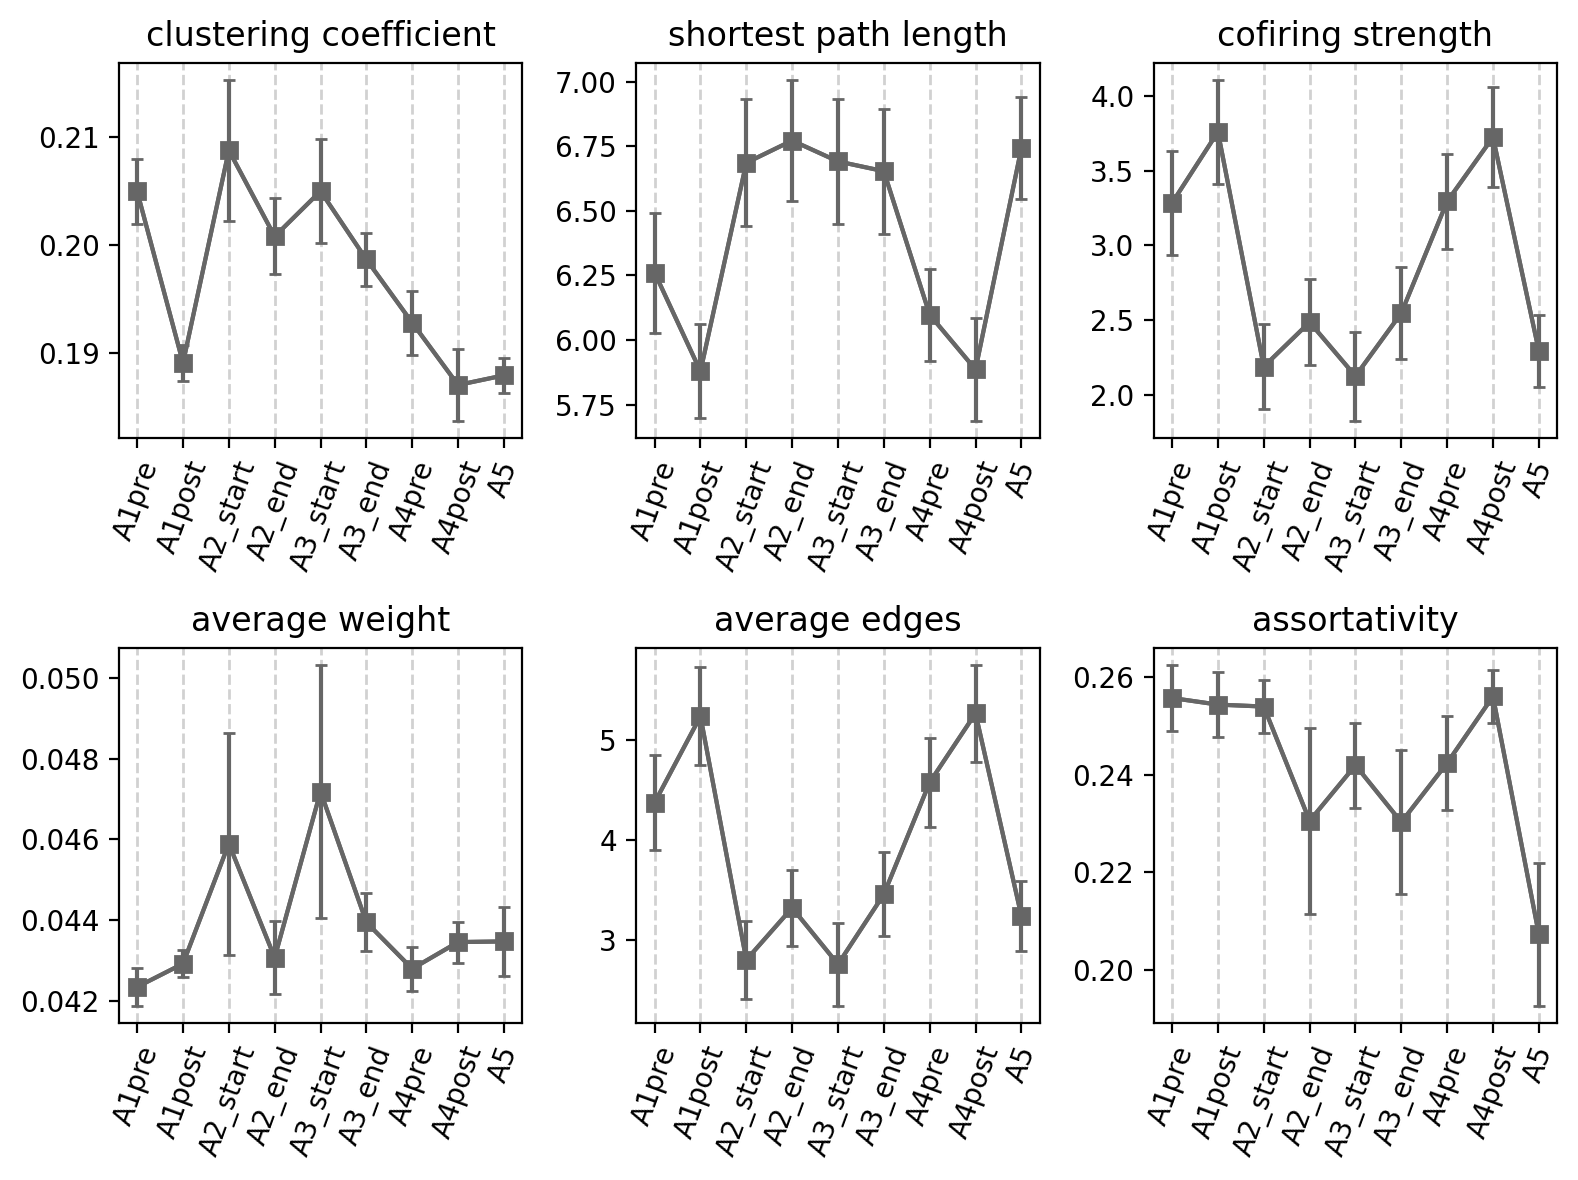

In [7]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(8, 6), tight_layout=True, dpi=200)

x = ['A1pre', 'A1post', 'A2_start', 'A2_end', 'A3_start', 'A3_end', 'A4pre', 'A4post', 'A5']
a = [0, 1, 2, 3, 4, 6, 7, 8, 9]
summary_df = df.iloc[:, 0:54]
clustering_cff_df = summary_df.iloc[:, 0::6]
clustering_cff_mean, clustering_cff_sem = clustering_cff_df.mean(), clustering_cff_df.sem()
axes[0][0].errorbar(x, clustering_cff_mean, yerr=clustering_cff_sem, capsize=2, color='0.4')
axes[0][0].plot(x, clustering_cff_mean, marker="s", markersize=6, color='0.4')
axes[0][0].set_title('clustering coefficient')
axes[0][0].set_xticklabels(x, rotation=70)
axes[0][0].grid(which = "major", axis = "x", color = "0.7", alpha = 0.6, linestyle = "--", linewidth = 1)

shortest_path_df = summary_df.iloc[:, 1::6]
shortest_path_mean, shortest_path_sem = shortest_path_df.mean(), shortest_path_df.sem()
axes[0][1].errorbar(x, shortest_path_mean, yerr=shortest_path_sem, capsize=2, color='0.4')
axes[0][1].plot(x, shortest_path_mean, marker="s", markersize=6, color='0.4')
axes[0][1].set_title('shortest path length')
axes[0][1].set_xticklabels(x, rotation=70)
axes[0][1].grid(which = "major", axis = "x", color = "0.7", alpha = 0.6, linestyle = "--", linewidth = 1)

cofiring_strength_df = summary_df.iloc[:, 2::6]
cofiring_strength_mean, cofiring_strength_sem = cofiring_strength_df.mean(), cofiring_strength_df.sem()
axes[0][2].errorbar(x, cofiring_strength_mean, yerr=cofiring_strength_sem, capsize=2, color='0.4')
axes[0][2].plot(x, cofiring_strength_mean, marker="s", markersize=6, color='0.4')
axes[0][2].set_title('cofiring strength')
axes[0][2].set_xticklabels(x, rotation=70)
axes[0][2].grid(which = "major", axis = "x", color = "0.7", alpha = 0.6, linestyle = "--", linewidth = 1)

total_weight_df = summary_df.iloc[:, 3::6]
total_weight_mean, total_weight_sem = total_weight_df.mean(), total_weight_df.sem()
axes[1][0].errorbar(x, total_weight_mean, yerr=total_weight_sem, capsize=2, color='0.4')
axes[1][0].plot(x, total_weight_mean, marker="s", markersize=6, color='0.4')
axes[1][0].set_title('average weight')
axes[1][0].set_xticklabels(x, rotation=70)
axes[1][0].grid(which = "major", axis = "x", color = "0.7", alpha = 0.6, linestyle = "--", linewidth = 1)

total_edge_df = summary_df.iloc[:, 4::6]
total_edge_mean, total_edge_sem = total_edge_df.mean(), total_edge_df.sem()
axes[1][1].errorbar(x, total_edge_mean, yerr=total_edge_sem, capsize=2, color='0.4')
axes[1][1].plot(x, total_edge_mean, marker="s", markersize=6, color='0.4')
axes[1][1].set_title('average edges')
axes[1][1].set_xticklabels(x, rotation=70)
axes[1][1].grid(which = "major", axis = "x", color = "0.7", alpha = 0.6, linestyle = "--", linewidth = 1)

assortativity_df = summary_df.iloc[:, 5::6]
assortativity_mean, assortativity_sem = assortativity_df.mean(), assortativity_df.sem()
axes[1][2].errorbar(x, assortativity_mean, yerr=assortativity_sem, capsize=2, color='0.4')
axes[1][2].plot(x, assortativity_mean, marker="s", markersize=6, color='0.4')
axes[1][2].set_title('assortativity')
axes[1][2].set_xticklabels(x, rotation=70)
axes[1][2].grid(which = "major", axis = "x", color = "0.7", alpha = 0.6, linestyle = "--", linewidth = 1)

fig.show()

In [8]:
df_without_extinction = df.drop(columns=df.columns[list(range(12, 36))])
df_without_extinction

context                       A1pre                                          \
feature      clustering coefficient shortest path length co-firing strength   
ID181106CreA               0.214388             6.993076           2.282826   
ID181106CreB               0.204347             6.371344           2.772396   
ID181106CreC               0.201963             5.542466           4.490692   
ID181106CreG               0.198179             5.641437           4.082693   
ID181106CreH               0.225771             6.563676           2.844471   
ID181106CreI               0.196647             7.768279           1.452557   
ID181106CreK               0.205997             6.478593           2.704456   
ID181106CreL               0.209772             5.840368           3.914885   
ID181106CreN               0.196260             6.013893           3.227792   
ID181106CreQ               0.195958             5.393550           5.085074   

context                                                  \
feature      average weight average edges assortativity   
ID181106CreA       0.043494      2.989041      0.265615   
ID181106CreB       0.041598      3.675103      0.243387   
ID181106CreC       0.041852      6.022309      0.267339   
ID181106CreG       0.042283      5.535518      0.268122   
ID181106CreH       0.040663      3.566329      0.276247   
ID181106CreI       0.045809      1.950982      0.205897   
ID181106CreK       0.041973      3.585247      0.247410   
ID181106CreL       0.040862      5.119019      0.259771   
ID181106CreN       0.042555      4.404478      0.244356   
ID181106CreQ       0.042374      6.914952      0.279176   

context                      A1post                                          \
feature      clustering coefficient shortest path length co-firing strength   
ID181106CreA               0.185498             5.984051           3.186339   
ID181106CreB               0.196356             6.285964           2.913137   
ID181106CreC               0.182992             5.406643           4.812617   
ID181106CreG               0.180988             5.469788           4.582944   
ID181106CreH               0.194372             5.848639           3.531883   
ID181106CreI               0.190592             7.257127           1.682850   
ID181106CreK               0.194710             6.009258           3.181203   
ID181106CreL               0.191436             5.507925           4.590617   
ID181106CreN               0.184023             5.732816           3.704797   
ID181106CreQ               0.189371             5.283829           5.432517   

context                      ...               A4_2                 \
feature      average weight  ... co-firing strength average weight   
ID181106CreA       0.043148  ...           4.214435       0.043004   
ID181106CreB       0.042168  ...           3.768092       0.043815   
ID181106CreC       0.042547  ...           6.019050       0.044918   
ID181106CreG       0.043061  ...           5.952415       0.045094   
ID181106CreH       0.042381  ...           5.487425       0.048995   
ID181106CreI       0.045680  ...           2.373951       0.042392   
ID181106CreK       0.043117  ...           4.618199       0.048106   
ID181106CreL       0.042071  ...           6.636618       0.049527   
ID181106CreN       0.042769  ...           4.687470       0.044221   
ID181106CreQ       0.042279  ...           7.146024       0.045228   

context                                                    A4_3  \
feature      average edges assortativity clustering coefficient   
ID181106CreA      6.220000      0.350929               0.205956   
ID181106CreB      5.340909      0.343357               0.181344   
ID181106CreC      9.323529      0.211101               0.159496   
ID181106CreG      8.626866      0.335707               0.180447   
ID181106CreH      7.263158      0.437432               0.185167   
ID181106CreI      3.413793      0.159701               0.204357   
ID181106CreK    

<ipython-input-9-87ae263035c1>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0][0].set_xticklabels(x, rotation=70)
<ipython-input-9-87ae263035c1>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0][1].set_xticklabels(x, rotation=70)
<ipython-input-9-87ae263035c1>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0][2].set_xticklabels(x, rotation=70)
<ipython-input-9-87ae263035c1>:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1][0].set_xticklabels(x, rotation=70)
<ipython-input-9-87ae263035c1>:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1][1].set_xticklabels(x, rotation=70)
<ipython-input-9-87ae263035c1>:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1][2].set_xticklabels(x, rotation=70)


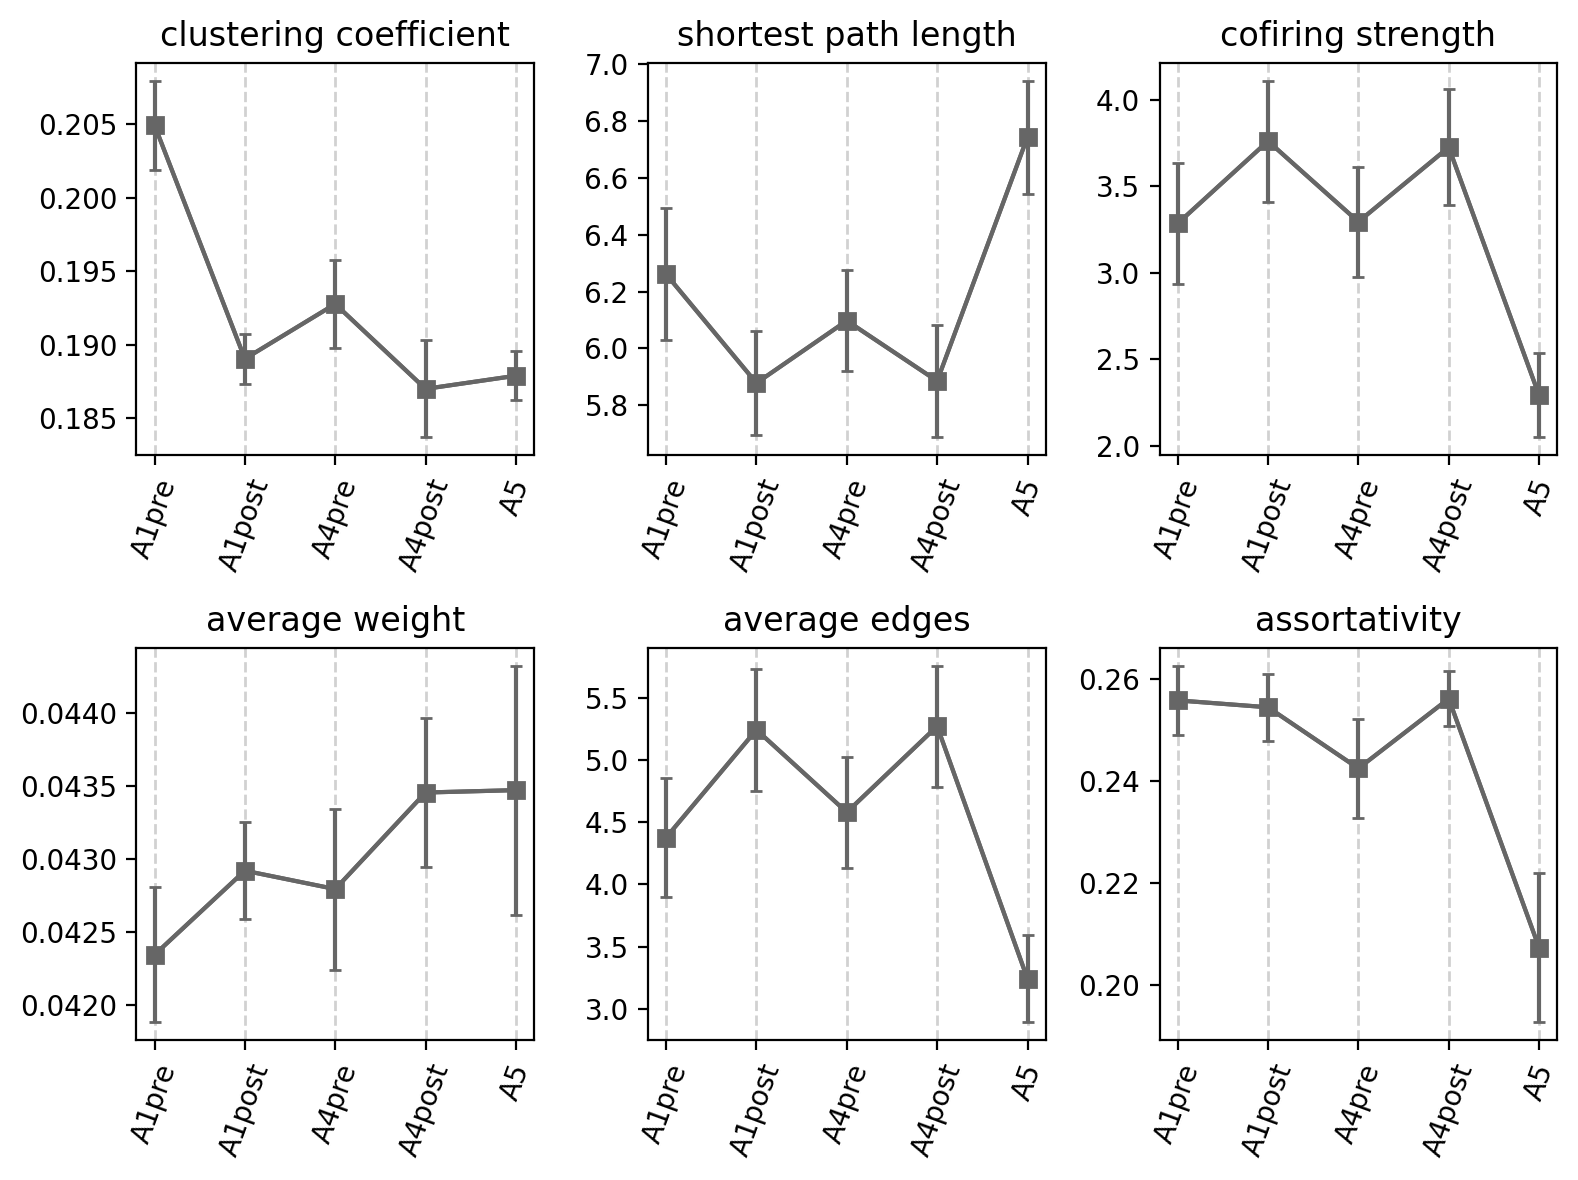

In [9]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(8, 6), tight_layout=True, dpi=200)

x = ['A1pre', 'A1post', 'A4pre', 'A4post', 'A5']
a = [0, 1, 2, 3, 4, 6, 7, 8, 9]
summary_df = df_without_extinction.iloc[:, 0:30]
clustering_cff_df = summary_df.iloc[:, 0::6]
clustering_cff_mean, clustering_cff_sem = clustering_cff_df.mean(), clustering_cff_df.sem()
axes[0][0].errorbar(x, clustering_cff_mean, yerr=clustering_cff_sem, capsize=2, color='0.4')
axes[0][0].plot(x, clustering_cff_mean, marker="s", markersize=6, color='0.4')
axes[0][0].set_title('clustering coefficient')
axes[0][0].set_xticklabels(x, rotation=70)
axes[0][0].grid(which = "major", axis = "x", color = "0.7", alpha = 0.6, linestyle = "--", linewidth = 1)

shortest_path_df = summary_df.iloc[:, 1::6]
shortest_path_mean, shortest_path_sem = shortest_path_df.mean(), shortest_path_df.sem()
axes[0][1].errorbar(x, shortest_path_mean, yerr=shortest_path_sem, capsize=2, color='0.4')
axes[0][1].plot(x, shortest_path_mean, marker="s", markersize=6, color='0.4')
axes[0][1].set_title('shortest path length')
axes[0][1].set_xticklabels(x, rotation=70)
axes[0][1].grid(which = "major", axis = "x", color = "0.7", alpha = 0.6, linestyle = "--", linewidth = 1)

cofiring_strength_df = summary_df.iloc[:, 2::6]
cofiring_strength_mean, cofiring_strength_sem = cofiring_strength_df.mean(), cofiring_strength_df.sem()
axes[0][2].errorbar(x, cofiring_strength_mean, yerr=cofiring_strength_sem, capsize=2, color='0.4')
axes[0][2].plot(x, cofiring_strength_mean, marker="s", markersize=6, color='0.4')
axes[0][2].set_title('cofiring strength')
axes[0][2].set_xticklabels(x, rotation=70)
axes[0][2].grid(which = "major", axis = "x", color = "0.7", alpha = 0.6, linestyle = "--", linewidth = 1)

total_weight_df = summary_df.iloc[:, 3::6]
total_weight_mean, total_weight_sem = total_weight_df.mean(), total_weight_df.sem()
axes[1][0].errorbar(x, total_weight_mean, yerr=total_weight_sem, capsize=2, color='0.4')
axes[1][0].plot(x, total_weight_mean, marker="s", markersize=6, color='0.4')
axes[1][0].set_title('average weight')
axes[1][0].set_xticklabels(x, rotation=70)
axes[1][0].grid(which = "major", axis = "x", color = "0.7", alpha = 0.6, linestyle = "--", linewidth = 1)

total_edge_df = summary_df.iloc[:, 4::6]
total_edge_mean, total_edge_sem = total_edge_df.mean(), total_edge_df.sem()
axes[1][1].errorbar(x, total_edge_mean, yerr=total_edge_sem, capsize=2, color='0.4')
axes[1][1].plot(x, total_edge_mean, marker="s", markersize=6, color='0.4')
axes[1][1].set_title('average edges')
axes[1][1].set_xticklabels(x, rotation=70)
axes[1][1].grid(which = "major", axis = "x", color = "0.7", alpha = 0.6, linestyle = "--", linewidth = 1)

assortativity_df = summary_df.iloc[:, 5::6]
assortativity_mean, assortativity_sem = assortativity_df.mean(), assortativity_df.sem()
axes[1][2].errorbar(x, assortativity_mean, yerr=assortativity_sem, capsize=2, color='0.4')
axes[1][2].plot(x, assortativity_mean, marker="s", markersize=6, color='0.4')
axes[1][2].set_title('assortativity')
axes[1][2].set_xticklabels(x, rotation=70)
axes[1][2].grid(which = "major", axis = "x", color = "0.7", alpha = 0.6, linestyle = "--", linewidth = 1)

fig.show()

In [10]:
sorted_df = df_without_extinction[['A1pre', 'A1_1', 'A1_2', 'A1_3', 'A4pre', 'A4_1', 'A4_2', 'A4_3', 'A5']]
sorted_df

context                       A1pre                                          \
feature      clustering coefficient shortest path length co-firing strength   
ID181106CreA               0.214388             6.993076           2.282826   
ID181106CreB               0.204347             6.371344           2.772396   
ID181106CreC               0.201963             5.542466           4.490692   
ID181106CreG               0.198179             5.641437           4.082693   
ID181106CreH               0.225771             6.563676           2.844471   
ID181106CreI               0.196647             7.768279           1.452557   
ID181106CreK               0.205997             6.478593           2.704456   
ID181106CreL               0.209772             5.840368           3.914885   
ID181106CreN               0.196260             6.013893           3.227792   
ID181106CreQ               0.195958             5.393550           5.085074   

context                                                  \
feature      average weight average edges assortativity   
ID181106CreA       0.043494      2.989041      0.265615   
ID181106CreB       0.041598      3.675103      0.243387   
ID181106CreC       0.041852      6.022309      0.267339   
ID181106CreG       0.042283      5.535518      0.268122   
ID181106CreH       0.040663      3.566329      0.276247   
ID181106CreI       0.045809      1.950982      0.205897   
ID181106CreK       0.041973      3.585247      0.247410   
ID181106CreL       0.040862      5.119019      0.259771   
ID181106CreN       0.042555      4.404478      0.244356   
ID181106CreQ       0.042374      6.914952      0.279176   

context                        A1_1                                          \
feature      clustering coefficient shortest path length co-firing strength   
ID181106CreA               0.198109             5.975064           4.085196   
ID181106CreB               0.190096             6.002583           3.684511   
ID181106CreC               0.169107             5.171198           5.466801   
ID181106CreG               0.149081             5.205927           5.634844   
ID181106CreH               0.194407             5.159936           5.064213   
ID181106CreI               0.195524             6.504790           2.445566   
ID181106CreK               0.192376             5.477834           4.195737   
ID181106CreL               0.185399             5.176822           5.990103   
ID181106CreN               0.166515             5.317505           4.471138   
ID181106CreQ               0.178426             5.121130           6.456239   

context                      ...               A4_3                 \
feature      average weight  ... co-firing strength average weight   
ID181106CreA       0.041686  ...           4.449772       0.046352   
ID181106CreB       0.043863  ...           3.558272       0.041375   
ID181106CreC       0.041415  ...           6.065937       0.045268   
ID181106CreG       0.042688  ...           5.825034       0.044808   
ID181106CreH       0.045216  ...           4.598038       0.041800   
ID181106CreI       0.043671  ...           2.460917       0.043945   
ID181106CreK       0.043706  ...           4.156922       0.043301   
ID181106CreL       0.044702  ...           6.464630       0.048974   
ID181106CreN       0.042181  ...           5.782723       0.054554   
ID181106CreQ       0.041924  ...           7.016444       0.044408   

context                                                      A5  \
feature      average edges assortativity clustering coefficient   
ID181106CreA      6.387755      0.395332               0.187390   
ID181106CreB      4.931818      0.437724               0.190498   
ID181106CreC      9.455882      0.274811               0.185061   
ID181106CreG      8.560606      0.289682               0.178157   
ID181106CreH      6.428571      0.132270               0.184586   
ID181106CreI      3.482759      0.072619               0.187044   
ID181106CreK    

<ipython-input-11-a9375ee64683>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0][0].set_xticklabels(x, rotation=70)
<ipython-input-11-a9375ee64683>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0][1].set_xticklabels(x, rotation=70)
<ipython-input-11-a9375ee64683>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0][2].set_xticklabels(x, rotation=70)
<ipython-input-11-a9375ee64683>:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1][0].set_xticklabels(x, rotation=70)
<ipython-input-11-a9375ee64683>:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1][1].set_xticklabels(x, rotation=70)
<ipython-input-11-a9375ee64683>:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1][2].set_xticklabels(x, rotation=70)


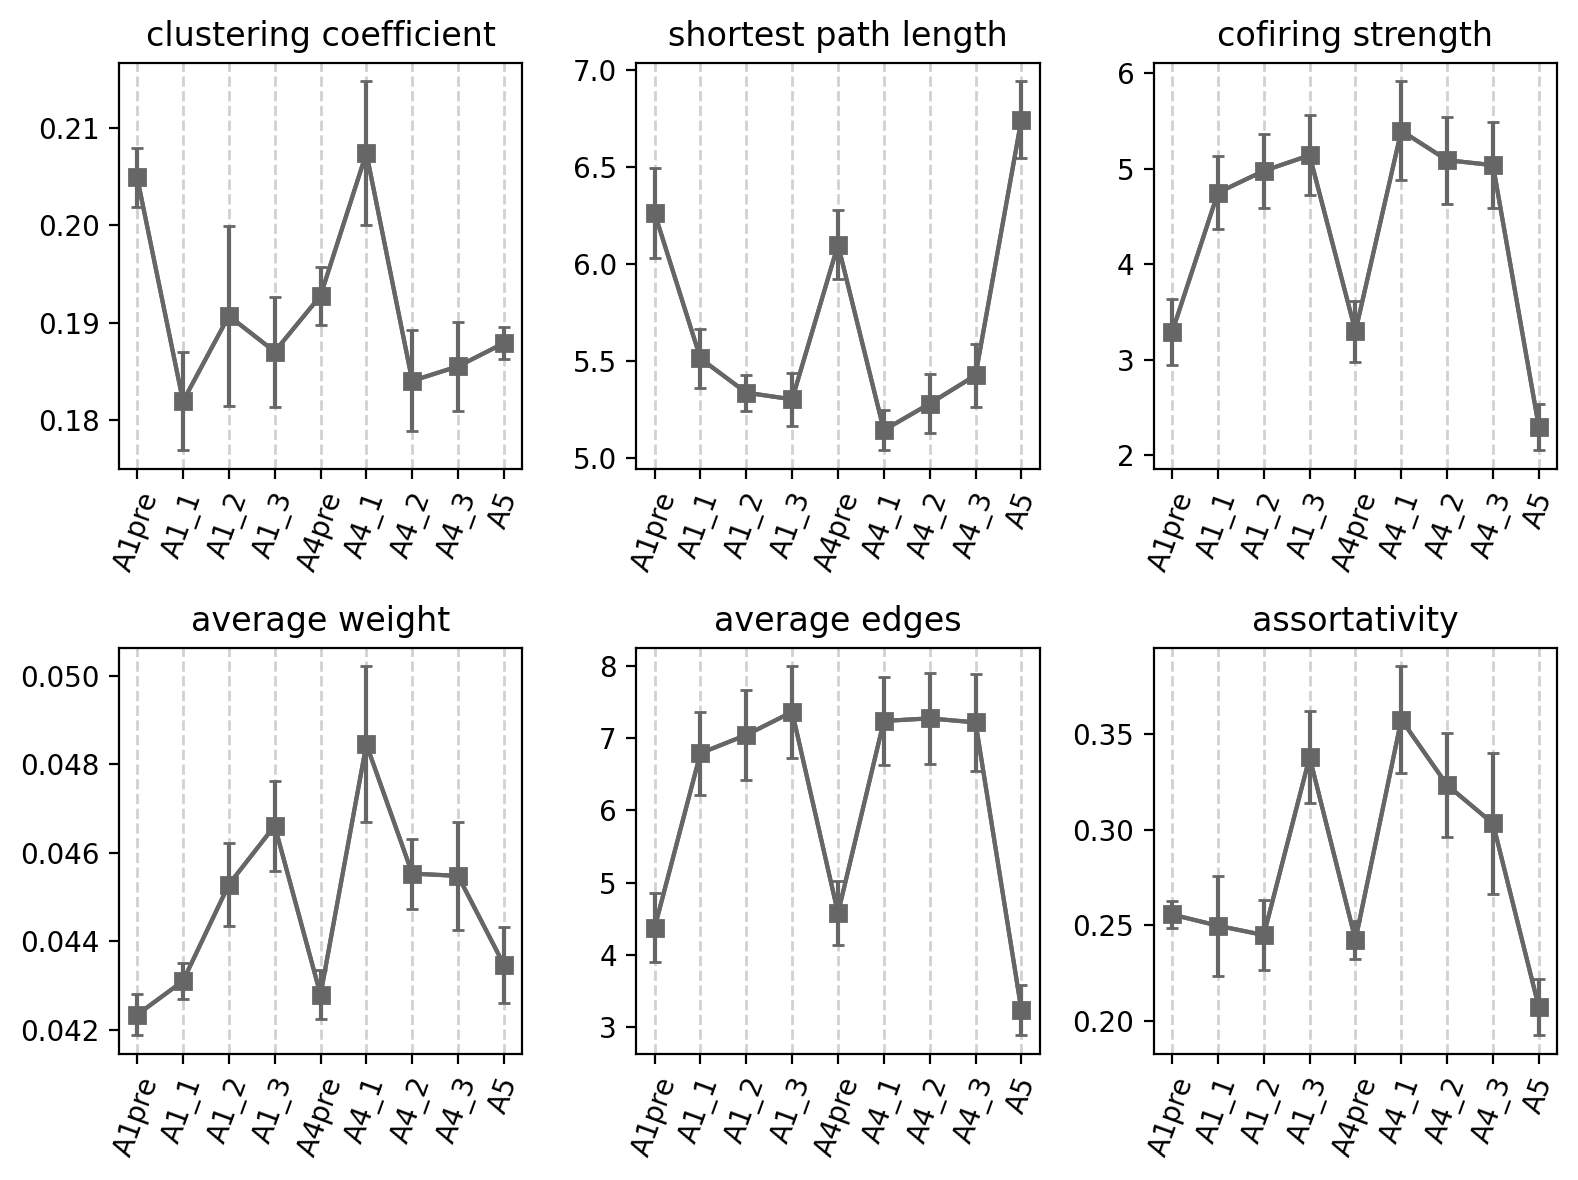

In [11]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(8, 6), tight_layout=True, dpi=200)

x = ['A1pre', 'A1_1', 'A1_2', 'A1_3', 'A4pre', 'A4_1', 'A4_2', 'A4_3', 'A5']
a = [0, 1, 2, 3, 4, 6, 7, 8, 9]
summary_df = sorted_df.iloc[:, 0:54]
clustering_cff_df = summary_df.iloc[:, 0::6]
clustering_cff_mean, clustering_cff_sem = clustering_cff_df.mean(), clustering_cff_df.sem()
axes[0][0].errorbar(x, clustering_cff_mean, yerr=clustering_cff_sem, capsize=2, color='0.4')
axes[0][0].plot(x, clustering_cff_mean, marker="s", markersize=6, color='0.4')
axes[0][0].set_title('clustering coefficient')
axes[0][0].set_xticklabels(x, rotation=70)
axes[0][0].grid(which = "major", axis = "x", color = "0.7", alpha = 0.6, linestyle = "--", linewidth = 1)

shortest_path_df = summary_df.iloc[:, 1::6]
shortest_path_mean, shortest_path_sem = shortest_path_df.mean(), shortest_path_df.sem()
axes[0][1].errorbar(x, shortest_path_mean, yerr=shortest_path_sem, capsize=2, color='0.4')
axes[0][1].plot(x, shortest_path_mean, marker="s", markersize=6, color='0.4')
axes[0][1].set_title('shortest path length')
axes[0][1].set_xticklabels(x, rotation=70)
axes[0][1].grid(which = "major", axis = "x", color = "0.7", alpha = 0.6, linestyle = "--", linewidth = 1)

cofiring_strength_df = summary_df.iloc[:, 2::6]
cofiring_strength_mean, cofiring_strength_sem = cofiring_strength_df.mean(), cofiring_strength_df.sem()
axes[0][2].errorbar(x, cofiring_strength_mean, yerr=cofiring_strength_sem, capsize=2, color='0.4')
axes[0][2].plot(x, cofiring_strength_mean, marker="s", markersize=6, color='0.4')
axes[0][2].set_title('cofiring strength')
axes[0][2].set_xticklabels(x, rotation=70)
axes[0][2].grid(which = "major", axis = "x", color = "0.7", alpha = 0.6, linestyle = "--", linewidth = 1)

total_weight_df = summary_df.iloc[:, 3::6]
total_weight_mean, total_weight_sem = total_weight_df.mean(), total_weight_df.sem()
axes[1][0].errorbar(x, total_weight_mean, yerr=total_weight_sem, capsize=2, color='0.4')
axes[1][0].plot(x, total_weight_mean, marker="s", markersize=6, color='0.4')
axes[1][0].set_title('average weight')
axes[1][0].set_xticklabels(x, rotation=70)
axes[1][0].grid(which = "major", axis = "x", color = "0.7", alpha = 0.6, linestyle = "--", linewidth = 1)

total_edge_df = summary_df.iloc[:, 4::6]
total_edge_mean, total_edge_sem = total_edge_df.mean(), total_edge_df.sem()
axes[1][1].errorbar(x, total_edge_mean, yerr=total_edge_sem, capsize=2, color='0.4')
axes[1][1].plot(x, total_edge_mean, marker="s", markersize=6, color='0.4')
axes[1][1].set_title('average edges')
axes[1][1].set_xticklabels(x, rotation=70)
axes[1][1].grid(which = "major", axis = "x", color = "0.7", alpha = 0.6, linestyle = "--", linewidth = 1)

assortativity_df = summary_df.iloc[:, 5::6]
assortativity_mean, assortativity_sem = assortativity_df.mean(), assortativity_df.sem()
axes[1][2].errorbar(x, assortativity_mean, yerr=assortativity_sem, capsize=2, color='0.4')
axes[1][2].plot(x, assortativity_mean, marker="s", markersize=6, color='0.4')
axes[1][2].set_title('assortativity')
axes[1][2].set_xticklabels(x, rotation=70)
axes[1][2].grid(which = "major", axis = "x", color = "0.7", alpha = 0.6, linestyle = "--", linewidth = 1)

fig.show()

<ipython-input-12-d1e47fb561b2>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0][0].set_xticklabels(x, rotation=45)
<ipython-input-12-d1e47fb561b2>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0][1].set_xticklabels(x, rotation=45)
<ipython-input-12-d1e47fb561b2>:26: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0][2].set_xticklabels(x, rotation=45)
<ipython-input-12-d1e47fb561b2>:38: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1][0].set_xticklabels(x, rotation=45)
<ipython-input-12-d1e47fb561b2>:45: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1][1].set_xticklabels(x, rotation=45)
<ipython-input-12-d1e47fb561b2>:52: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1][2].set_xticklabels(x, rotation=45)
<ipython-input-12-d1e47fb561b2>:64: UserWarning: FixedFormatter 

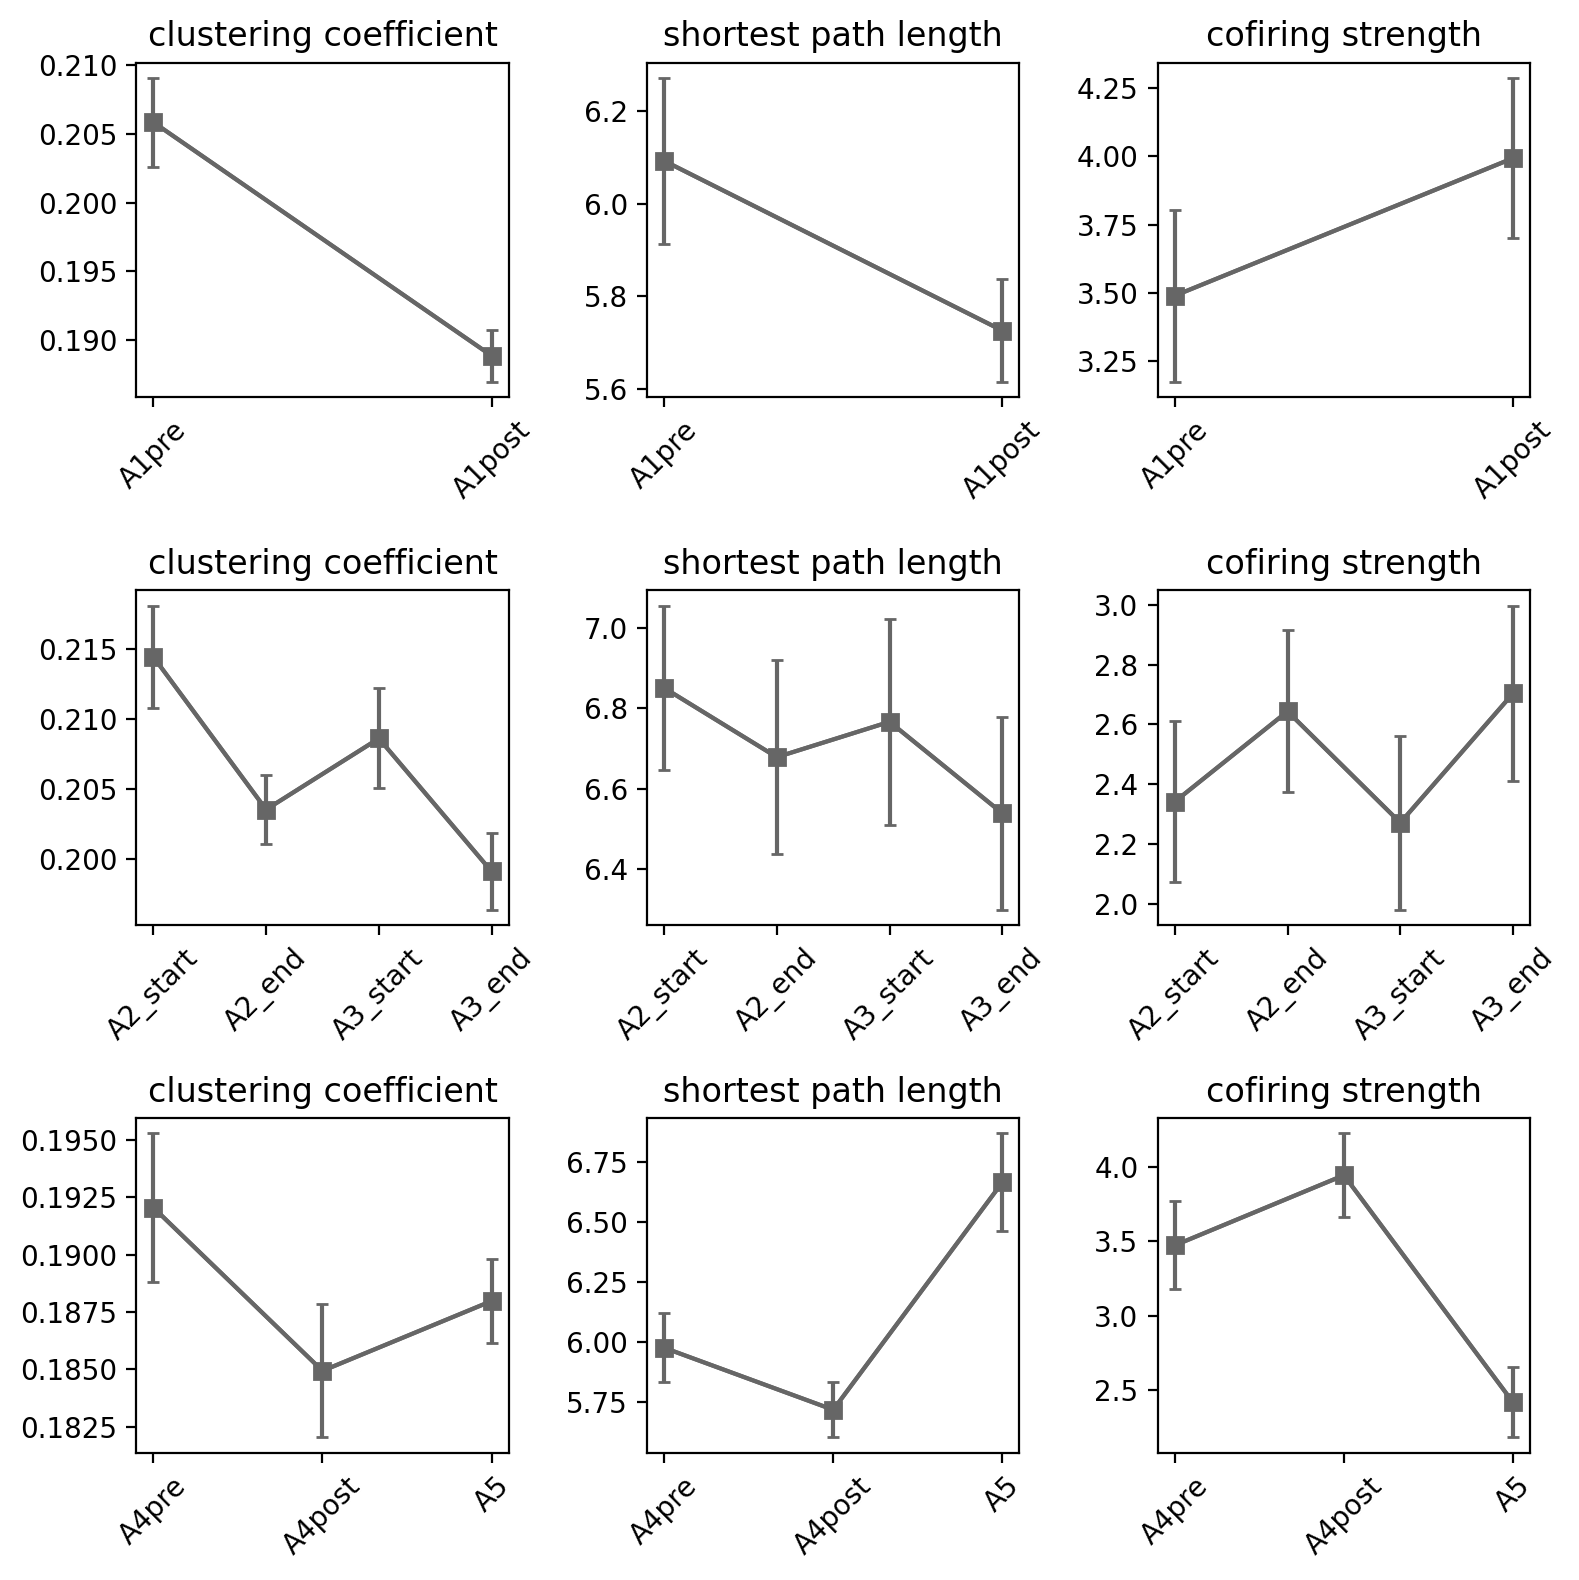

In [12]:
fig, axes = plt.subplots(ncols=3, nrows=3, figsize=(8, 8), tight_layout=True, dpi=200)

# A1
x = ['A1pre', 'A1post']
a = [0, 1, 2, 3, 4, 6, 7, 8, 9]
summary_df = df.iloc[a, 0:12]
clustering_cff_df = summary_df.iloc[:, 0::6]
clustering_cff_mean, clustering_cff_sem = clustering_cff_df.mean(), clustering_cff_df.sem()
axes[0][0].errorbar(x, clustering_cff_mean, yerr=clustering_cff_sem, capsize=2, color='0.4')
axes[0][0].plot(x, clustering_cff_mean, marker="s", markersize=6, color='0.4')
axes[0][0].set_title('clustering coefficient')
axes[0][0].set_xticklabels(x, rotation=45)

shortest_path_df = summary_df.iloc[:, 1::6]
shortest_path_mean, shortest_path_sem = shortest_path_df.mean(), shortest_path_df.sem()
axes[0][1].errorbar(x, shortest_path_mean, yerr=shortest_path_sem, capsize=2, color='0.4')
axes[0][1].plot(x, shortest_path_mean, marker="s", markersize=6, color='0.4')
axes[0][1].set_title('shortest path length')
axes[0][1].set_xticklabels(x, rotation=45)

cofiring_strength_df = summary_df.iloc[:, 2::6]
cofiring_strength_mean, cofiring_strength_sem = cofiring_strength_df.mean(), cofiring_strength_df.sem()
axes[0][2].errorbar(x, cofiring_strength_mean, yerr=cofiring_strength_sem, capsize=2, color='0.4')
axes[0][2].plot(x, cofiring_strength_mean, marker="s", markersize=6, color='0.4')
axes[0][2].set_title('cofiring strength')
axes[0][2].set_xticklabels(x, rotation=45)

# A2, A3

x = ['A2_start', 'A2_end', 'A3_start', 'A3_end']
a = [0, 1, 2, 3, 4, 6, 7, 8, 9]
summary_df = df.iloc[a, 12:36]
clustering_cff_df = summary_df.iloc[:, 0::6]
clustering_cff_mean, clustering_cff_sem = clustering_cff_df.mean(), clustering_cff_df.sem()
axes[1][0].errorbar(x, clustering_cff_mean, yerr=clustering_cff_sem, capsize=2, color='0.4')
axes[1][0].plot(x, clustering_cff_mean, marker="s", markersize=6, color='0.4')
axes[1][0].set_title('clustering coefficient')
axes[1][0].set_xticklabels(x, rotation=45)

shortest_path_df = summary_df.iloc[:, 1::6]
shortest_path_mean, shortest_path_sem = shortest_path_df.mean(), shortest_path_df.sem()
axes[1][1].errorbar(x, shortest_path_mean, yerr=shortest_path_sem, capsize=2, color='0.4')
axes[1][1].plot(x, shortest_path_mean, marker="s", markersize=6, color='0.4')
axes[1][1].set_title('shortest path length')
axes[1][1].set_xticklabels(x, rotation=45)

cofiring_strength_df = summary_df.iloc[:, 2::6]
cofiring_strength_mean, cofiring_strength_sem = cofiring_strength_df.mean(), cofiring_strength_df.sem()
axes[1][2].errorbar(x, cofiring_strength_mean, yerr=cofiring_strength_sem, capsize=2, color='0.4')
axes[1][2].plot(x, cofiring_strength_mean, marker="s", markersize=6, color='0.4')
axes[1][2].set_title('cofiring strength')
axes[1][2].set_xticklabels(x, rotation=45)

# A4, A5

x = ['A4pre', 'A4post', 'A5']
a = [0, 1, 2, 3, 4, 6, 7, 8, 9]
summary_df = df.iloc[a, 36:54]
clustering_cff_df = summary_df.iloc[:, 0::6]
clustering_cff_mean, clustering_cff_sem = clustering_cff_df.mean(), clustering_cff_df.sem()
axes[2][0].errorbar(x, clustering_cff_mean, yerr=clustering_cff_sem, capsize=2, color='0.4')
axes[2][0].plot(x, clustering_cff_mean, marker="s", markersize=6, color='0.4')
axes[2][0].set_title('clustering coefficient')
axes[2][0].set_xticklabels(x, rotation=45)

shortest_path_df = summary_df.iloc[:, 1::6]
shortest_path_mean, shortest_path_sem = shortest_path_df.mean(), shortest_path_df.sem()
axes[2][1].errorbar(x, shortest_path_mean, yerr=shortest_path_sem, capsize=2, color='0.4')
axes[2][1].plot(x, shortest_path_mean, marker="s", markersize=6, color='0.4')
axes[2][1].set_title('shortest path length')
axes[2][1].set_xticklabels(x, rotation=45)

cofiring_strength_df = summary_df.iloc[:, 2::6]
cofiring_strength_mean, cofiring_strength_sem = cofiring_strength_df.mean(), cofiring_strength_df.sem()
axes[2][2].errorbar(x, cofiring_strength_mean, yerr=cofiring_strength_sem, capsize=2, color='0.4')
axes[2][2].plot(x, cofiring_strength_mean, marker="s", markersize=6, color='0.4')
axes[2][2].set_title('cofiring strength')
axes[2][2].set_xticklabels(x, rotation=45)

fig.show()

<ipython-input-13-825dd2d46555>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0][0].set_xticklabels(x, rotation=70)
<ipython-input-13-825dd2d46555>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0][1].set_xticklabels(x, rotation=70)
<ipython-input-13-825dd2d46555>:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0][2].set_xticklabels(x, rotation=70)
<ipython-input-13-825dd2d46555>:35: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1][0].set_xticklabels(x, rotation=70)
<ipython-input-13-825dd2d46555>:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1][1].set_xticklabels(x, rotation=70)
<ipython-input-13-825dd2d46555>:51: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1][2].set_xticklabels(x, rotation=70)


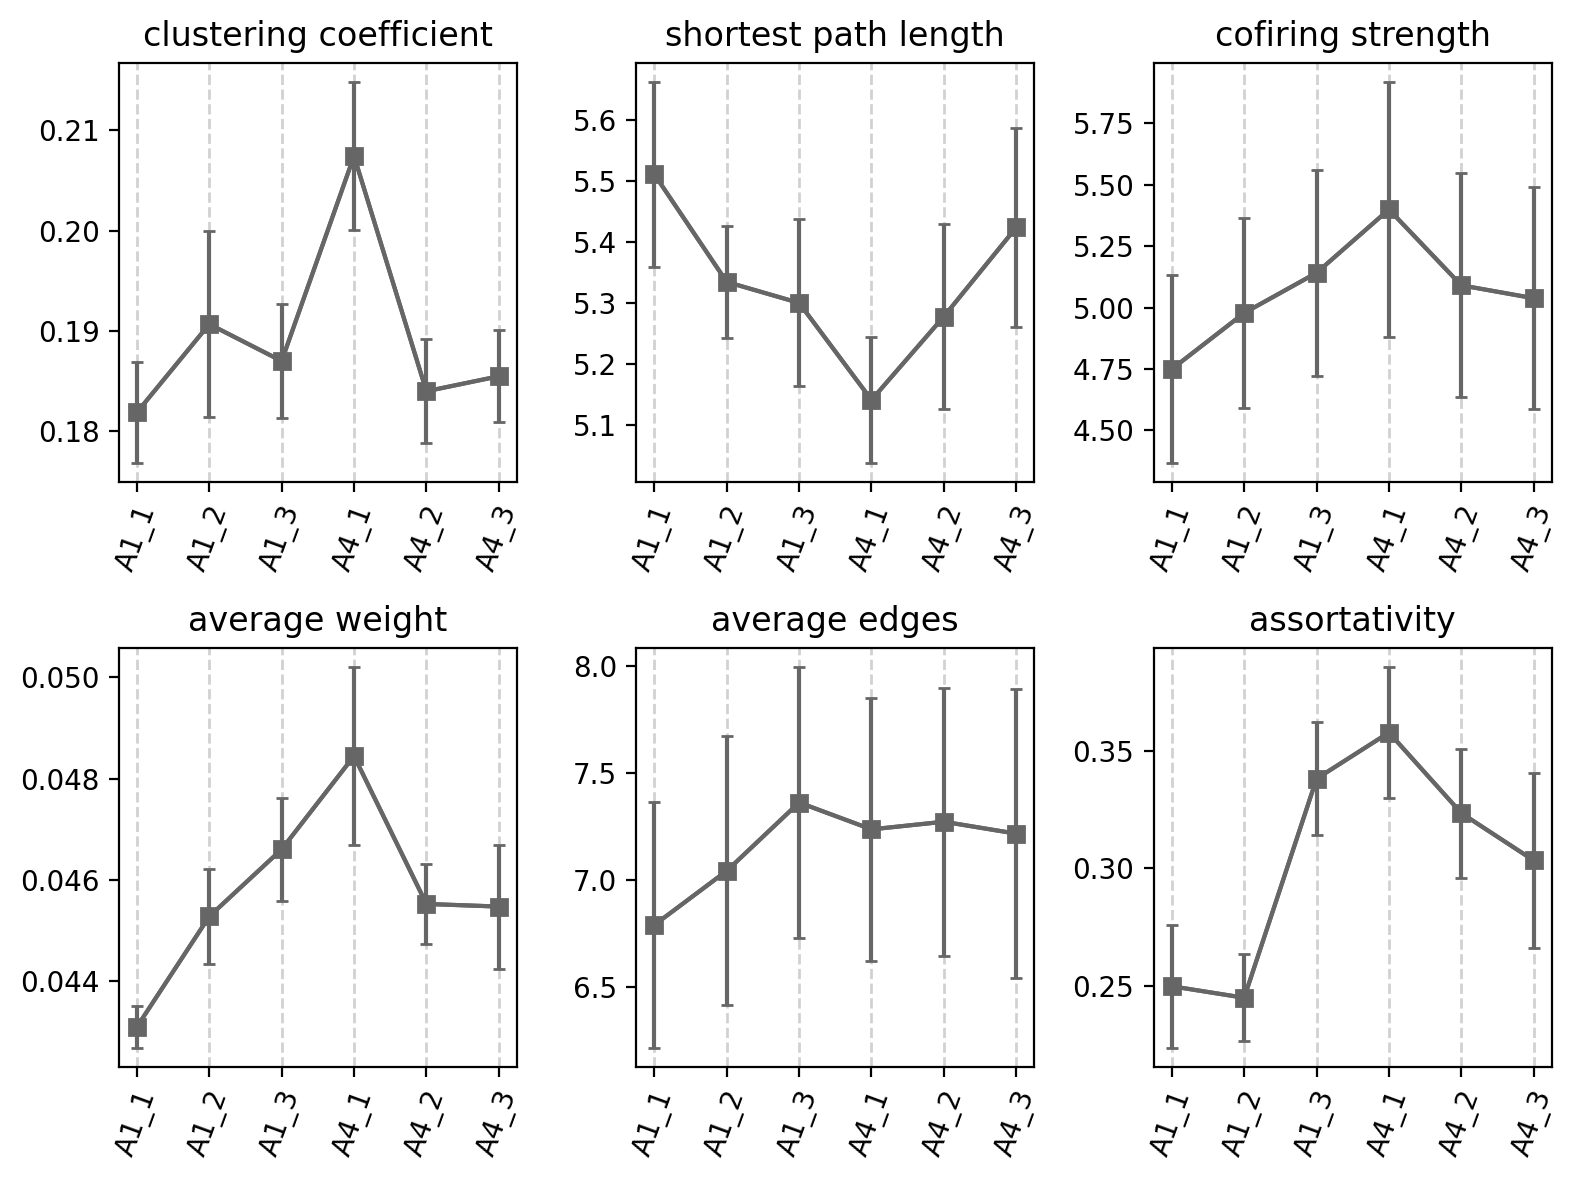

In [13]:
fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(8, 6), tight_layout=True, dpi=200)

x = ['A1_1', 'A1_2', 'A1_3', 'A4_1', 'A4_2', 'A4_3']
a = [0, 1, 2, 3, 4, 6, 7, 8, 9]
summary_df = df.iloc[:, 54:]
clustering_cff_df = summary_df.iloc[:, 0::6]
clustering_cff_mean, clustering_cff_sem = clustering_cff_df.mean(), clustering_cff_df.sem()
axes[0][0].errorbar(x, clustering_cff_mean, yerr=clustering_cff_sem, capsize=2, color='0.4')
axes[0][0].plot(x, clustering_cff_mean, marker="s", markersize=6, color='0.4')
axes[0][0].set_title('clustering coefficient')
axes[0][0].set_xticklabels(x, rotation=70)
axes[0][0].grid(which = "major", axis = "x", color = "0.7", alpha = 0.6, linestyle = "--", linewidth = 1)

shortest_path_df = summary_df.iloc[:, 1::6]
shortest_path_mean, shortest_path_sem = shortest_path_df.mean(), shortest_path_df.sem()
axes[0][1].errorbar(x, shortest_path_mean, yerr=shortest_path_sem, capsize=2, color='0.4')
axes[0][1].plot(x, shortest_path_mean, marker="s", markersize=6, color='0.4')
axes[0][1].set_title('shortest path length')
axes[0][1].set_xticklabels(x, rotation=70)
axes[0][1].grid(which = "major", axis = "x", color = "0.7", alpha = 0.6, linestyle = "--", linewidth = 1)

cofiring_strength_df = summary_df.iloc[:, 2::6]
cofiring_strength_mean, cofiring_strength_sem = cofiring_strength_df.mean(), cofiring_strength_df.sem()
axes[0][2].errorbar(x, cofiring_strength_mean, yerr=cofiring_strength_sem, capsize=2, color='0.4')
axes[0][2].plot(x, cofiring_strength_mean, marker="s", markersize=6, color='0.4')
axes[0][2].set_title('cofiring strength')
axes[0][2].set_xticklabels(x, rotation=70)
axes[0][2].grid(which = "major", axis = "x", color = "0.7", alpha = 0.6, linestyle = "--", linewidth = 1)

total_weight_df = summary_df.iloc[:, 3::6]
total_weight_mean, total_weight_sem = total_weight_df.mean(), total_weight_df.sem()
axes[1][0].errorbar(x, total_weight_mean, yerr=total_weight_sem, capsize=2, color='0.4')
axes[1][0].plot(x, total_weight_mean, marker="s", markersize=6, color='0.4')
axes[1][0].set_title('average weight')
axes[1][0].set_xticklabels(x, rotation=70)
axes[1][0].grid(which = "major", axis = "x", color = "0.7", alpha = 0.6, linestyle = "--", linewidth = 1)

total_edge_df = summary_df.iloc[:, 4::6]
total_edge_mean, total_edge_sem = total_edge_df.mean(), total_edge_df.sem()
axes[1][1].errorbar(x, total_edge_mean, yerr=total_edge_sem, capsize=2, color='0.4')
axes[1][1].plot(x, total_edge_mean, marker="s", markersize=6, color='0.4')
axes[1][1].set_title('average edges')
axes[1][1].set_xticklabels(x, rotation=70)
axes[1][1].grid(which = "major", axis = "x", color = "0.7", alpha = 0.6, linestyle = "--", linewidth = 1)

assortativity_df = summary_df.iloc[:, 5::6]
assortativity_mean, assortativity_sem = assortativity_df.mean(), assortativity_df.sem()
axes[1][2].errorbar(x, assortativity_mean, yerr=assortativity_sem, capsize=2, color='0.4')
axes[1][2].plot(x, assortativity_mean, marker="s", markersize=6, color='0.4')
axes[1][2].set_title('assortativity')
axes[1][2].set_xticklabels(x, rotation=70)
axes[1][2].grid(which = "major", axis = "x", color = "0.7", alpha = 0.6, linestyle = "--", linewidth = 1)

fig.show()

In [14]:
df.iloc[:, 54:].describe().iloc[:, 2::6]

context,A1_1,A1_2,A1_3,A4_1,A4_2,A4_3
feature,co-firing strength,co-firing strength,co-firing strength,co-firing strength,co-firing strength,co-firing strength
count,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000
mean,4.749435,4.977813,5.141139,5.399101,5.090368,5.037869
std,1.207256,1.218818,1.328103,1.643860,1.439896,1.427003
min,2.445566,2.776100,2.524326,2.707290,2.373951,2.460917
25%,4.112831,4.434674,4.334667,4.468343,4.315376,4.230134
50%,4.767676,4.809760,5.286854,5.210211,5.087448,5.190381
75%,5.592833,5.994267,5.979485,6.521717,6.002391,6.005711
max,6.456239,6.720120,7.029422,8.400163,7.146024,7.016444


In [15]:
from scipy.stats import f_oneway

# clustering coefficient
a1_pre = df.iloc[:, 0]
a1_post = df.iloc[:, 6]
# a2_start = df.iloc[:, 12]
# a2_end = df.iloc[:, 18]
# a3_start = df.iloc[:, 24]
# a3_end = df.iloc[:, 30]
a4_pre = df.iloc[:, 36]
a4_post = df.iloc[:, 42]
a5 = df.iloc[:, 48]

_, pvalue = f_oneway(a1_pre, a1_post, a4_pre, a4_post, a5)
print('pvalue of clustering coefficient: %f' % pvalue)

# shortest path length
a1_pre = df.iloc[:, 1]
a1_post = df.iloc[:, 7]
# a2_start = df.iloc[:, 13]
# a2_end = df.iloc[:, 19]
# a3_start = df.iloc[:, 25]
# a3_end = df.iloc[:, 31]
a4_pre = df.iloc[:, 37]
a4_post = df.iloc[:, 43]
a5 = df.iloc[:, 49]

_, pvalue = f_oneway(a1_pre, a1_post, a4_pre, a4_post, a5)
print('pvalue of shortest path length: %f' % pvalue)

# cofiring strength
a1_pre = df.iloc[:, 2]
a1_post = df.iloc[:, 8]
# a2_start = df.iloc[:, 9]
# a2_end = df.iloc[:, 20]
# a3_start = df.iloc[:, 26]
# a3_end = df.iloc[:, 32]
a4_pre = df.iloc[:, 38]
a4_post = df.iloc[:, 44]
a5 = df.iloc[:, 50]

_, pvalue = f_oneway(a1_pre, a1_post, a4_pre, a4_post, a5)
print('pvalue of cofiring strength: %f' % pvalue)

# assortativity
a1_pre = df.iloc[:, 5].fillna(0.0)
a1_post = df.iloc[:, 11].fillna(0.0)
# a2_start = df.iloc[:, 17].fillna(0.0)
# a2_end = df.iloc[:, 23].fillna(0.0)
# a3_start = df.iloc[:, 29].fillna(0.0)
# a3_end = df.iloc[:, 35].fillna(0.0)
a4_pre = df.iloc[:, 41].fillna(0.0)
a4_post = df.iloc[:, 47].fillna(0.0)
a5 = df.iloc[:, 53].fillna(0.0)

_, pvalue = f_oneway(a1_pre, a1_post, a4_pre, a4_post, a5)
print('pvalue of assortativity: %f' % pvalue)

pvalue of clustering coefficient: 0.000067
pvalue of shortest path length: 0.021157
pvalue of cofiring strength: 0.016360
pvalue of assortativity: 0.001836


In [16]:
df.iloc[:, 54:]

context                        A1_1                                          \
feature      clustering coefficient shortest path length co-firing strength   
ID181106CreA               0.198109             5.975064           4.085196   
ID181106CreB               0.190096             6.002583           3.684511   
ID181106CreC               0.169107             5.171198           5.466801   
ID181106CreG               0.149081             5.205927           5.634844   
ID181106CreH               0.194407             5.159936           5.064213   
ID181106CreI               0.195524             6.504790           2.445566   
ID181106CreK               0.192376             5.477834           4.195737   
ID181106CreL               0.185399             5.176822           5.990103   
ID181106CreN               0.166515             5.317505           4.471138   
ID181106CreQ               0.178426             5.121130           6.456239   

context                                                  \
feature      average weight average edges assortativity   
ID181106CreA       0.041686      5.440000      0.401705   
ID181106CreB       0.043863      5.023256      0.345460   
ID181106CreC       0.041415      7.910448      0.207540   
ID181106CreG       0.042688      8.925373      0.216646   
ID181106CreH       0.045216      7.175439      0.265123   
ID181106CreI       0.043671      3.517241      0.277368   
ID181106CreK       0.043706      5.816327      0.160650   
ID181106CreL       0.044702      8.250000      0.286366   
ID181106CreN       0.042181      6.851852      0.128971   
ID181106CreQ       0.041924      9.000000      0.208597   

context                        A1_2                                          \
feature      clustering coefficient shortest path length co-firing strength   
ID181106CreA               0.187574             5.515437           4.413621   
ID181106CreB               0.169335             5.508737           3.731597   
ID181106CreC               0.197157             4.963383           6.204499   
ID181106CreG               0.165323             5.164569           6.081112   
ID181106CreH               0.167593             5.690369           4.497832   
ID181106CreI               0.248362             5.833265           2.776100   
ID181106CreK               0.237655             5.061684           4.677817   
ID181106CreL               0.176307             5.347782           5.733733   
ID181106CreN               0.181936             5.188159           4.941702   
ID181106CreQ               0.175624             5.076434           6.720120   

context                      ...               A4_2                 \
feature      average weight  ... co-firing strength average weight   
ID181106CreA       0.045975  ...           4.214435       0.043004   
ID181106CreB       0.043391  ...           3.768092       0.043815   
ID181106CreC       0.047004  ...           6.019050       0.044918   
ID181106CreG       0.046069  ...           5.952415       0.045094   
ID181106CreH       0.040159  ...           5.487425       0.048995   
ID181106CreI       0.049573  ...           2.373951       0.042392   
ID181106CreK       0.048727  ...           4.618199       0.048106   
ID181106CreL       0.042789  ...           6.636618       0.049527   
ID181106CreN       0.046620  ...           4.687470       0.044221   
ID181106CreQ       0.042532  ...           7.146024       0.045228   

context                                                    A4_3  \
feature      average edges assortativity clustering coefficient   
ID181106CreA      6.220000      0.350929               0.205956   
ID181106CreB      5.340909      0.343357               0.181344   
ID181106CreC      9.323529      0.211101               0.159496   
ID181106CreG      8.626866      0.335707               0.180447   
ID181106CreH      7.263158      0.437432               0.185167   
ID181106CreI      3.413793      0.159701               0.204357   
ID181106CreK    

In [17]:
df.to_csv('./resources/graph_result.csv')